<img src= "img/pipelines.png" style="height:450px">


[Image Source](https://towardsdatascience.com/using-functiontransformer-and-pipeline-in-sklearn-to-predict-chardonnay-ratings-9b13fdd6c6fd)

__Agenda__

- Pipelines and Composite estimators

- Why do we need them?

- How to use them in sklearn: accessing a particular object in pipe and changing parameters

- ROC Curve

- Area under ROC Curve

In [114]:
import pandas as pd
import numpy as np

# Pipelines

__What is a Pipeline?__

_Transformers:_ Any object with .transform method. Ex: StandardScaler, OneHotEncoder.

_Estimators:_ Any object with predict method. Ex: RandomForestClassifier, LinearRegression etc.

_Pipelines:_ A tool for combining transformers with estimators. 


__Why do we need pipelines?__

- Convenience and encapsulation

Even though we train 10 transformers and 5 estimators we will call fit and predict once.

- Joint parameter selection - here emphasize preprocessing part

We can put pipelines into gridsearch and find best parameters for all the estimators at once.

- Safety

Pipelines help avoid leaking statistics from your test data into trained model.

[Pipelines and Composite Estimators](https://scikit-learn.org/stable/modules/compose.html#combining-estimators)



## Usage of Pipelines

The Pipeline is built using a list of (key, value) pairs, where the key is a string containing the name you want to give this step and value is an estimator object:

In [115]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# give these functions text-based names:
estimators = [('imputer', SimpleImputer()),
              ('scaler', StandardScaler()),
              ('clf', LogisticRegression())]

pipe = Pipeline(estimators)

pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('clf', LogisticRegression())])

__Your Turn__

- Create your own pipeline. You can use the same transformers and estimators with different parameters and 'name'.

- You can create a new pipe with a scaler also.

In [116]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

In [117]:
# This is an object inside of pipeline. The namespace of pipeline doesn't care about what's in your_pipe.
# pass it in the Pipeline object
from sklearn.tree import DecisionTreeClassifier
your_estimators = [('knnimputer', KNNImputer()),
                   ('scaler', MinMaxScaler(0,100)),
                   ('clf', DecisionTreeClassifier(max_depth=3))]
your_pipe = Pipeline(your_estimators)
your_pipe

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass copy=100 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Pipeline(steps=[('knnimputer', KNNImputer()),
                ('scaler', MinMaxScaler(copy=100, feature_range=0)),
                ('clf', DecisionTreeClassifier(max_depth=3))])

Sklearn also gives us "make_pipeline" which is almost the same thing but with make_pipeline you don't have to give names.

__Your Turn__

-  [Check documentation: 6.1.1.1.1 Construction](https://scikit-learn.org/stable/modules/compose.html) and use `make_pipeline` to construct a pipeline.

In [118]:
from sklearn.pipeline import make_pipeline

In [119]:
your_make_pipe = make_pipeline(KNNImputer(), MinMaxScaler(feature_range = (0,100)), DecisionTreeClassifier(max_depth=3))
your_make_pipe

Pipeline(steps=[('knnimputer', KNNImputer()),
                ('minmaxscaler', MinMaxScaler(feature_range=(0, 100))),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=3))])

In [120]:
# ^Two ways of making pipeline. The difference is just the names for the pipelines. 

## Accessing steps

We have multiple ways to access and object in the pipeline

In [121]:
pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('clf', LogisticRegression())])

In [122]:
pipe.steps

[('imputer', SimpleImputer()),
 ('scaler', StandardScaler()),
 ('clf', LogisticRegression())]

In [123]:
## note that these will all give the simple imputer object
# pipe[0]

# pipe['imputer']

pipe.steps[0][1]

SimpleImputer()

In [124]:
## We can also access a particular object by named_steps

pipe.named_steps.imputer

SimpleImputer()

In [125]:
## We can 'slice' pipelines to create sub-pipes

pipe[1:]

Pipeline(steps=[('scaler', StandardScaler()), ('clf', LogisticRegression())])

## Access to the parameters

Parameters of the estimators in the pipeline can be accessed using the 
"estimator__parameter" syntax.

In [126]:
pipe.named_steps.clf

LogisticRegression()

In [127]:
_.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [128]:
# update clf C to 10: function name__parameter name
pipe.set_params(clf__C = 10)

pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('clf', LogisticRegression(C=10))])

In [129]:
pipe.named_steps.scaler

StandardScaler()

In [130]:
_.get_params()

{'copy': True, 'with_mean': True, 'with_std': True}

In [131]:
pipe.set_params(scaler__with_std = False)

pipe

Pipeline(steps=[('imputer', SimpleImputer()),
                ('scaler', StandardScaler(with_std=False)),
                ('clf', LogisticRegression(C=10))])

## Pipelines in action

In [132]:
from sklearn.model_selection import train_test_split

[Dataset info](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)

In [133]:
import pandas as pd
df = pd.read_csv('./data/heart.csv')

In [134]:
print(df.shape)
df.head(3)

(303, 15)


,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes


In [135]:
df = df.drop(columns = 'Unnamed: 0')

In our dataset we have 303 patients and 13 independent variables and 1 binary target variable.

When we are working with classification problems it is always good practice to check the class balance.

In [136]:
df['AHD'].value_counts(normalize=True)

No     0.541254
Yes    0.458746
Name: AHD, dtype: float64

We see that approximately 54% of the patients are in the class 0 which refers to 'no presence' of a heart disease. Consequently, 45% of the patients have a heart disease. 

## Creating Train-Test Split

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    object 
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         299 non-null    float64
 12  Thal       301 non-null    object 
 13  AHD        303 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 33.3+ KB


In [138]:
# For model evaluation we split our data into two parts: Train - Test

X = df.drop('AHD', axis=1)
y = df['AHD']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=77, stratify=y,
                                                    test_size=.2)

In [139]:
# Let's check number of 1 and 0 in both datasets
y_train.value_counts(normalize=True)

No     0.541322
Yes    0.458678
Name: AHD, dtype: float64

In [140]:
y_test.value_counts(normalize=True)

No     0.540984
Yes    0.459016
Name: AHD, dtype: float64

## Choosing a Perfomance Metric for Model Evaluations

__Model Selection vs Model Evaluation__

- Model Selection/Model Comparison: What is the best parameters for a given model. Between different models which one is better models the reality.

Ex: If we are working with an app that runs a machine learning algorithm model selection is choosing the process of choosing a final algorithm to deploy.


- Model Evaluation: After selecting a 'best' model with model selection how this model will perform in the 'real' case.

Ex: Model evaluation is where we want to predict how successful this algorithm will be.

[Available tools in sklearn](https://scikit-learn.org/stable/model_selection.html)

<img src= 'img/table.png' width = 450 />

## Data Prep Before Training a Model

[A good blog post on handling categorical variables](https://www.bogotobogo.com/python/scikit-learn/scikit_machine_learning_Data_Preprocessing-Missing-Data-Categorical-Data.php)

__Your Turn__

- Convert Categorical Variables to OneHotEncoding


In [141]:
# saving the steps in a list for creating pipeline later.
steps = []

In [142]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [143]:
ss = StandardScaler()

In [144]:
X.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal


In [145]:
# X has missing values
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    object 
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         299 non-null    float64
 12  Thal       301 non-null    object 
dtypes: float64(2), int64(9), object(2)
memory usage: 30.9+ KB


In [146]:
from sklearn.impute import SimpleImputer

si = SimpleImputer(strategy='most_frequent')
X_train_imputed = si.fit_transform(X_train)
X_test_imputed = si.transform(X_test)

In [147]:
# add to steps
steps.append(('imputer',si))

In [148]:
pd.DataFrame(X_train_imputed).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       242 non-null    object
 1   1       242 non-null    object
 2   2       242 non-null    object
 3   3       242 non-null    object
 4   4       242 non-null    object
 5   5       242 non-null    object
 6   6       242 non-null    object
 7   7       242 non-null    object
 8   8       242 non-null    object
 9   9       242 non-null    object
 10  10      242 non-null    object
 11  11      242 non-null    object
 12  12      242 non-null    object
dtypes: object(13)
memory usage: 24.7+ KB


In [149]:
X.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal


In [150]:
# create an encoder object. This will help us to convert
# categorical variables to new columns.

encoder = OneHotEncoder(drop='first')

# Create an columntransformer object.
# This will help us to merge transformed columns
# with the rest of the dataset.
catvars = [2,6,10,12]
# catvars = ['ChestPain', "RestECG", 'Slope', 'Thal']
ct = ColumnTransformer([('encoder', encoder, catvars)],
                       remainder='passthrough',
                       sparse_threshold=0) #returns dense (not sparse) matrix: show me all zeros. 
                            #Sparse matrix says where data lives rather than keeping the full matrix. 

X_train_transformed = ct.fit_transform(X_train_imputed)

In [151]:
X_train_transformed

array([[0.0, 0.0, 0.0, ..., 1, 5.6, 0.0],
       [0.0, 1.0, 0.0, ..., 0, 1.4, 1.0],
       [0.0, 0.0, 0.0, ..., 0, 0.0, 0.0],
       ...,
       [0.0, 1.0, 0.0, ..., 0, 0.0, 0.0],
       [0.0, 1.0, 0.0, ..., 0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 1, 0.1, 1.0]], dtype=object)

In [152]:
# save into steps

steps.append(('onehot',ct))

More on sparse matrix:

In [153]:
# Try the sparse matrix version
ct = ColumnTransformer([('encoder', encoder, catvars)],
                       remainder='passthrough',
                       sparse_threshold=0.9)
X_train_transformed_sparse = ct.fit_transform(X_train_imputed)

In [154]:
# sparse matrix format:
print(X_train_transformed_sparse[:5])

  (0, 6)	1.0
  (0, 8)	1.0
  (0, 9)	55.0
  (0, 10)	1.0
  (0, 11)	140.0
  (0, 12)	217.0
  (0, 14)	111.0
  (0, 15)	1.0
  (0, 16)	5.6
  (1, 1)	1.0
  (1, 4)	1.0
  (1, 5)	1.0
  (1, 8)	1.0
  (1, 9)	62.0
  (1, 10)	1.0
  (1, 11)	120.0
  (1, 12)	281.0
  (1, 14)	103.0
  (1, 16)	1.4
  (1, 17)	1.0
  (2, 7)	1.0
  (2, 9)	42.0
  (2, 10)	1.0
  (2, 11)	140.0
  (2, 12)	226.0
  (2, 14)	178.0
  (3, 4)	1.0
  (3, 8)	1.0
  (3, 9)	48.0
  (3, 10)	1.0
  (3, 11)	130.0
  (3, 12)	256.0
  (3, 13)	1.0
  (3, 14)	150.0
  (3, 15)	1.0
  (3, 17)	2.0
  (4, 1)	1.0
  (4, 4)	1.0
  (4, 7)	1.0
  (4, 9)	29.0
  (4, 10)	1.0
  (4, 11)	130.0
  (4, 12)	204.0
  (4, 14)	202.0


In [155]:
print(X_train_transformed_sparse[:5].toarray())

[[  0.    0.    0.    0.    0.    0.    1.    0.    1.   55.    1.  140.
  217.    0.  111.    1.    5.6   0. ]
 [  0.    1.    0.    0.    1.    1.    0.    0.    1.   62.    1.  120.
  281.    0.  103.    0.    1.4   1. ]
 [  0.    0.    0.    0.    0.    0.    0.    1.    0.   42.    1.  140.
  226.    0.  178.    0.    0.    0. ]
 [  0.    0.    0.    0.    1.    0.    0.    0.    1.   48.    1.  130.
  256.    1.  150.    1.    0.    2. ]
 [  0.    1.    0.    0.    1.    0.    0.    1.    0.   29.    1.  130.
  204.    0.  202.    0.    0.    0. ]]


In [156]:
pd.DataFrame(X_train_transformed_sparse)

,0
0,"(0, 6)\t1.0\n (0, 8)\t1.0\n (0, 9)\t55.0\n..."
1,"(0, 1)\t1.0\n (0, 4)\t1.0\n (0, 5)\t1.0\n ..."
2,"(0, 7)\t1.0\n (0, 9)\t42.0\n (0, 10)\t1.0\..."
3,"(0, 4)\t1.0\n (0, 8)\t1.0\n (0, 9)\t48.0\n..."
4,"(0, 1)\t1.0\n (0, 4)\t1.0\n (0, 7)\t1.0\n ..."
...,...
237,"(0, 4)\t1.0\n (0, 8)\t1.0\n (0, 9)\t46.0\n..."
238,"(0, 4)\t1.0\n (0, 7)\t1.0\n (0, 9)\t53.0\n..."
239,"(0, 1)\t1.0\n (0, 7)\t1.0\n (0, 9)\t44.0\n..."
240,"(0, 1)\t1.0\n (0, 5)\t1.0\n (0, 7)\t1.0\n ..."


In [157]:
pd.DataFrame(X_train_transformed_sparse.toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,55.0,1.0,140.0,217.0,0.0,111.0,1.0,5.6,0.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,62.0,1.0,120.0,281.0,0.0,103.0,0.0,1.4,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,42.0,1.0,140.0,226.0,0.0,178.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,48.0,1.0,130.0,256.0,1.0,150.0,1.0,0.0,2.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.0,1.0,130.0,204.0,0.0,202.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,46.0,1.0,120.0,249.0,0.0,144.0,0.0,0.8,0.0
238,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,53.0,0.0,138.0,234.0,0.0,160.0,0.0,0.0,0.0
239,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,44.0,1.0,120.0,220.0,0.0,170.0,0.0,0.0,0.0
240,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,49.0,0.0,134.0,271.0,0.0,162.0,0.0,0.0,0.0


__Don't forget!!__

- Apply the same transformations to the test data.

In [158]:
X_test_transformed = ct.transform(X_test_imputed)
X_test_transformed.shape

(61, 18)

In [159]:
ct.get_feature_names()

['encoder__x0_nonanginal',
 'encoder__x0_nontypical',
 'encoder__x0_typical',
 'encoder__x1_1',
 'encoder__x1_2',
 'encoder__x2_2',
 'encoder__x2_3',
 'encoder__x3_normal',
 'encoder__x3_reversable',
 'x0',
 'x1',
 'x3',
 'x4',
 'x5',
 'x7',
 'x8',
 'x9',
 'x11']

__Scaling Features__ 

-- Let's go back to the column transformer.

[Different Scalers and Their Effect on Data](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

In [160]:
from sklearn.preprocessing import StandardScaler

In [165]:
ss = StandardScaler()
X_train_final = ss.fit_transform(X_train_transformed)
X_test_final = ss.transform(X_test_transformed)

ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

In [166]:
X_train_final.shape

(242, 18)

In [167]:
X_test_final.shape

(61, 18)

In [168]:
# adding to steps list
steps.append(('scaler', ss))

## Model Training

[Check sklearn for documentation of Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


[For solvers](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [169]:
log_reg = LogisticRegression(penalty='none', max_iter=10000) # no regularization
steps.append(('lr', log_reg))

In [170]:
steps

[('imputer', SimpleImputer(strategy='most_frequent')),
 ('onehot',
  ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                    transformers=[('encoder', OneHotEncoder(drop='first'),
                                   [2, 6, 10, 12])])),
 ('scaler', StandardScaler()),
 ('lr', LogisticRegression(max_iter=10000, penalty='none'))]

In [171]:
pipe = Pipeline(steps)

In [172]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('encoder',
                                                  OneHotEncoder(drop='first'),
                                                  [2, 6, 10, 12])])),
                ('scaler', StandardScaler()),
                ('lr', LogisticRegression(max_iter=10000, penalty='none'))])

In [173]:
print(pipe.score(X_train, y_train))
# The accuracy associated with lr classifier

0.8760330578512396


In [174]:
print(pipe.score(X_test, y_test))

0.8360655737704918


## Confusion Matrix

In [175]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [176]:
y_pred = pipe.predict(X_train)

score = pipe.score(X_train, y_train)


In [177]:
cm = confusion_matrix(y_train, y_pred)

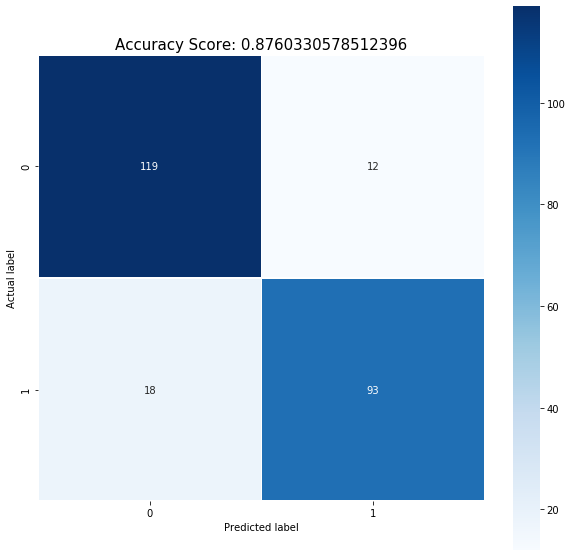

In [178]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5,
            square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size=15)
plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
# plt.show();

## ROC Curves for Model Selection

### Plotting ROC curves

In [ ]:
# The pipelines will handle all the OHE for us.

In [179]:
X = X_train

In [180]:
log_reg_vanilla = pipe

# do this step because when steps_l2 just point to steps, when we change it steps also changes
steps_l2 = steps.copy()


In [181]:
steps_l2[-1] = ('lr', LogisticRegression(penalty='l2', C=0.01, max_iter=10000))
log_reg_l2 = Pipeline(steps_l2)

In [195]:
# Fit and predict for train variables:
log_reg_vanilla.fit(X, y_train)
y_probs_vanilla = log_reg_vanilla.predict_proba(X)

In [196]:
log_reg_l2.fit(X, y_train)
y_probs_l2 = log_reg_l2.predict_proba(X)

In [184]:
import matplotlib.pyplot as plt

%matplotlib inline

In [185]:
from sklearn.metrics import roc_curve

In [186]:
# y not one hot encoded
y_train

123    Yes
137    Yes
35      No
120    Yes
132     No
      ... 
237    Yes
88      No
128     No
238     No
229    Yes
Name: AHD, Length: 242, dtype: object

In [187]:
y_train = y_train.map({'Yes':1, 'No':0})

In [197]:
log_reg_vanilla.predict(X)

array([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1])

In [201]:
# false positive rate, true positive rate
fpr_v, tpr_v, thresholds_v = roc_curve(y_train, y_probs_vanilla[:,1])
fpr_l2, tpr_l2, thresholds_l2 = roc_curve(y_train, y_probs_l2[:,1])

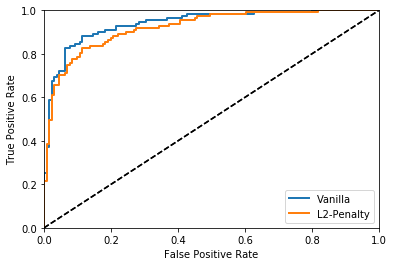

In [202]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


plot_roc_curve(fpr_v, tpr_v, label='Vanilla')
plot_roc_curve(fpr_l2, tpr_l2, label='L2-Penalty')
plt.legend()
plt.show()

In [204]:
# You can also draw the roc_auc curve with predicted y, but it'll be less nuanced:
fpr_v, tpr_v, thresholds_v = roc_curve(y_train, log_reg_vanilla.predict(X))
fpr_l2, tpr_l2, thresholds_l2 = roc_curve(y_train, log_reg_l2.predict(X))

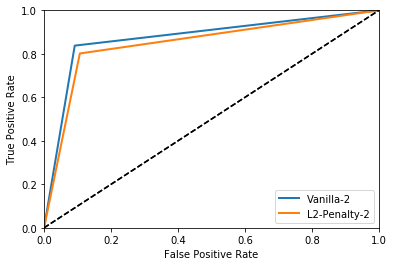

In [205]:
plot_roc_curve(fpr_v, tpr_v, label='Vanilla-2')
plot_roc_curve(fpr_l2, tpr_l2, label='L2-Penalty-2')
plt.legend()
plt.show()

Also we can measure the __A__rea __U__nder __C__urve scores


In [105]:
from sklearn.metrics import roc_auc_score

In [106]:
roc_auc_score(y_train, y_probs_vanilla[:,1])

0.9401004057492607

In [107]:
roc_auc_score(y_train, y_probs_l2[:,1])

0.9216697613644179

### The Default Measure (in most prebuilt models) - Accuracy

$$ \frac{(TP + TN)}{(TP + FP + TN + FN)} $$

Category definitions - possible outcomes in binary classification

- TP = True Positive (class 1 correctly classified as class 1) - e.g. Patient with cancer tests positive for cancer
- TN = True Negative (class 0 correctly classified as class 0) - e.g. Patient without cancer tests negative for cancer
- FP = False Positive (class 0 incorrectly classified as class 1) - e.g. Patient without cancer tests positive for cancer
- FN = False Negative (class 1 incorrectly classified as class 0) - e.g. Patient with cancer tests negative for cancer

 $$ \text{Possible misclassifications} $$

<img src='./img/type-1-type-2.jpg' width=400/>
 

Remember that Logistic Regression gives probability predictions for each class, in addition to the final classification. By default, threshold for the prediction is set to 0.5, but we can adjust that threshold.

### The AUC / ROC curve (Area Under Curve of the Receiver Operating Characteristic)

<img src='img/pop-curve.png' width=500/>


### Using Cross Validation Scores for Model Evaluation

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
log_reg = LogisticRegression(penalty='none', max_iter=10000)

In [ ]:
y_scores = cross_val_score(log_reg, X, y_train, cv=3, scoring='roc_auc')

In [ ]:
y_scores